In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import datetime as dt
import sys
import numpy as np
import pandas as pd
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [5]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [6]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [7]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [8]:
start = pd.Timestamp('2010-01-01')
end = pd.Timestamp('2022-04-29')

rf = web.DataReader('RELAXO.NS', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2677 entries, 2011-06-17 to 2022-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2677 non-null   float64
 1   Low        2677 non-null   float64
 2   Open       2677 non-null   float64
 3   Close      2677 non-null   float64
 4   Volume     2677 non-null   float64
 5   Adj Close  2677 non-null   float64
dtypes: float64(6)
memory usage: 146.4 KB


In [9]:
rf.head()

High      Low     Open    Close    Volume  Adj Close
Date                                                               
2011-06-17  14.9950  13.1500  14.9950  14.1775  317040.0  13.849187
2011-06-20  13.6000  13.1025  13.6000  13.1150   10080.0  12.811293
2011-06-21  13.2350  12.5050  12.9000  12.8750    7980.0  12.576848
2011-06-22  13.3975  11.6000  11.6000  12.2525     180.0  11.968763
2011-06-23  12.9500  12.0025  12.0025  12.5000    1900.0  12.210531

In [10]:
hurst(re)

NameError: name 're' is not defined

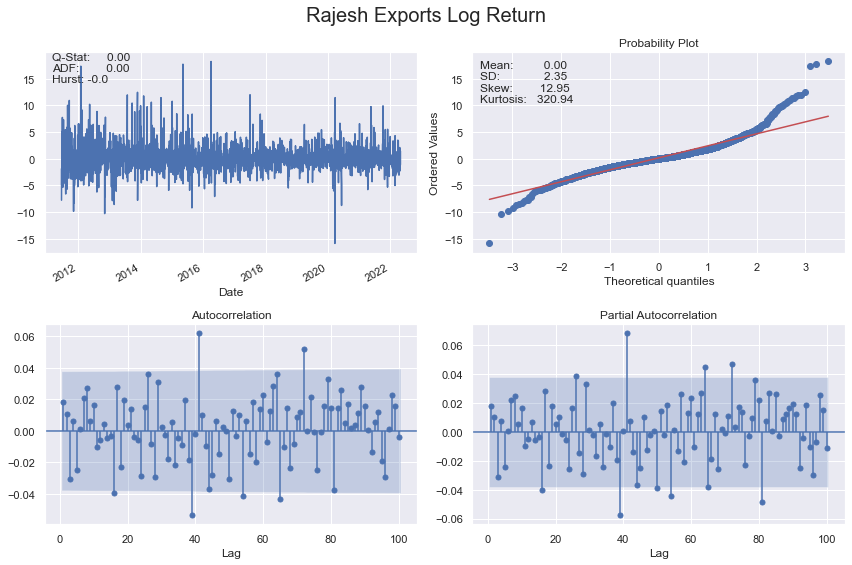

In [11]:
# Calculate daily returns as percentage price changes
rf['Return'] = 100 * (rf['Close'].pct_change())
rf['Log_Return'] = np.log(rf['Close']).diff().mul(100) # rescale to faciliate optimization
rf = rf.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(rf['Log_Return'], lags=100, title='Rajesh Exports Log Return')

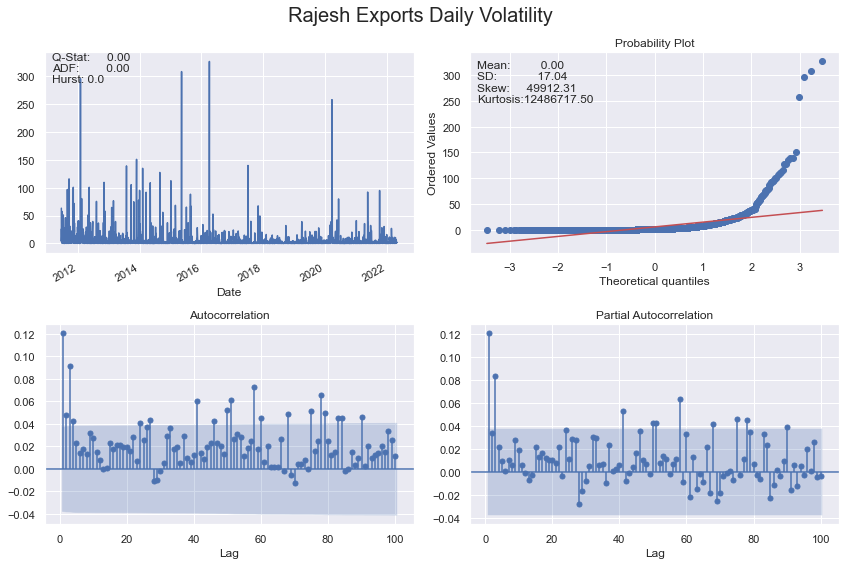

In [12]:
plot_correlogram(rf['Log_Return'].sub(rf['Log_Return'].mean()).pow(2), lags=100, title='Rajesh Exports Daily Volatility')

In [13]:
# Calculate daily std of returns
std_daily = rf['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.39%

Monthly volatility: 10.95%

Annual volatility: 37.94%


In [14]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

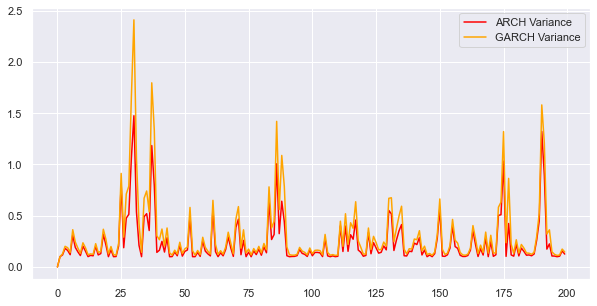

In [15]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

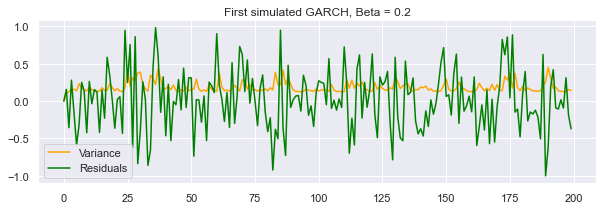

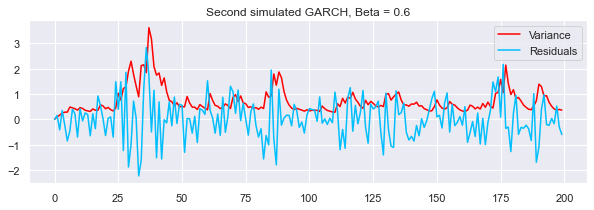

In [16]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

In [17]:
# Specify GARCH model assumptions
basic_gm = arch_model(rf['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     28,   Neg. LLF: 6068.972046145033
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5999.74838303091
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5999.747081285208
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11


In [18]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5999.75
Distribution:                  Normal   AIC:                           12007.5
Method:            Maximum Likelihood   BIC:                           12031.1
                                        No. Observations:                 2676
Date:                Tue, Sep 06 2022   Df Residuals:                     2675
Time:                        20:19:21   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1700  4.605e-02      3.691  2.232e-04 [7.971e-0

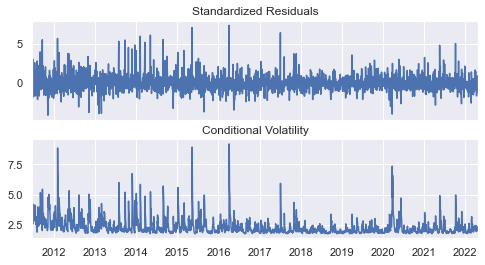

In [19]:
# Plot fitted results
gm_result.plot()
plt.show()

In [20]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                h.1       h.2       h.3       h.4       h.5
Date                                                       
2022-04-29  4.02781  4.468086  4.823545  5.110528  5.342226


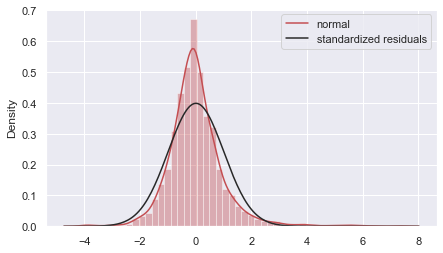

In [21]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [22]:
# Specify GARCH model assumptions
skewt_gm = arch_model(rf['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

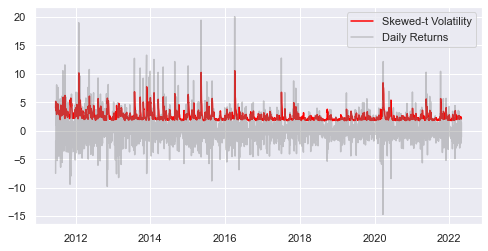

In [23]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(rf['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [24]:
import pmdarima as pm

model = pm.auto_arima(rf['Log_Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=12211.422, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=12197.209, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=12203.712, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=12203.754, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=12192.463, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=12199.483, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=12199.502, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=12207.313, Time=0.70 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.789 seconds


In [25]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2676
Model:                        SARIMAX   Log Likelihood               -6088.340
Date:                Tue, 06 Sep 2022   AIC                          12180.679
Time:                        20:19:28   BIC                          12192.463
Sample:                             0   HQIC                         12184.943
                               - 2676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1620      0.048      3.368      0.001       0.068       0.256
sigma2         5.5425      0.074     75.240      0.000       5.398       5.687
Ljung-Box (L1) (Q):                   0.87   Jarque-

In [26]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=rf['Log_Return'],order=(0, 0, 1))
_model_result = _arma_model.fit()

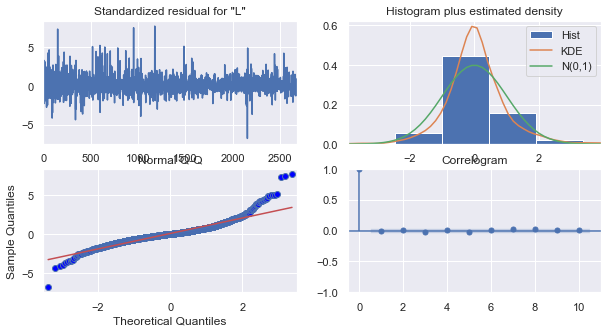

In [27]:
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [28]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5961.84
Distribution:                  Normal   AIC:                           11929.7
Method:            Maximum Likelihood   BIC:                           11947.3
                                        No. Observations:                 2676
Date:                Tue, Sep 06 2022   Df Residuals:                     2676
Time:                        20:19:29   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.1794      0.632      1.866  6.201e-02 [-5.92

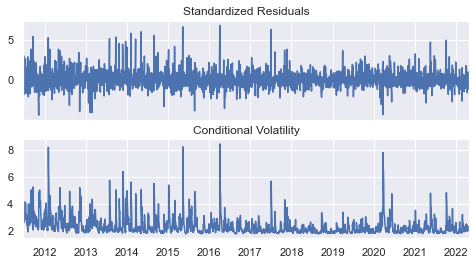

In [29]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

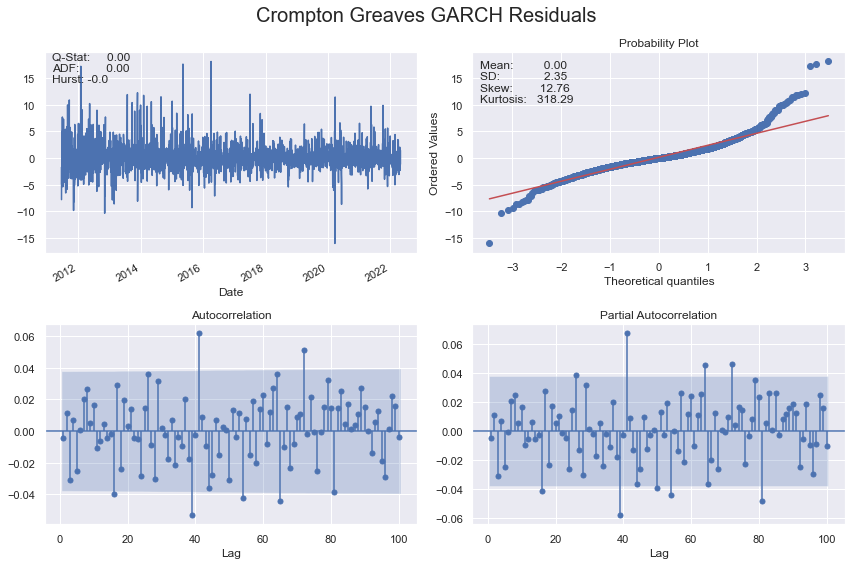

In [30]:
plot_correlogram(_garch_result.resid.dropna(), lags=100, title='Crompton Greaves GARCH Residuals')

In [31]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(rf['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5656.80
Distribution:      Standardized Student's t   AIC:                           11325.6
Method:                  Maximum Likelihood   BIC:                           11361.0
                                              No. Observations:                 2676
Date:                      Tue, Sep 06 2022   Df Residuals:                     2675
Time:                              20:19:31   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [32]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(rf['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5654.02
Distribution:      Standardized Student's t   AIC:                           11320.0
Method:                  Maximum Likelihood   BIC:                           11355.4
                                              No. Observations:                 2676
Date:                      Tue, Sep 06 2022   Df Residuals:                     2675
Time:                              20:19:32   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

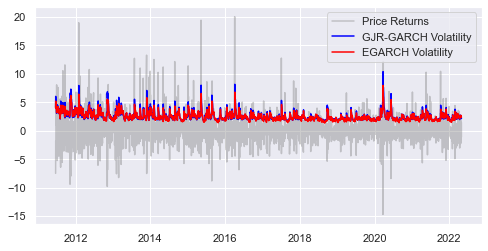

In [33]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual Bitcoin returns
plt.plot(rf['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [34]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 11360.959381091097

EGARCH BIC: 11355.396261022159


In [35]:
index = rf.index
start_loc = 0
end_loc = np.where(index >= '2022-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


In [36]:
index = rf.index
start_loc = 0
end_loc = np.where(index >= '2022-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


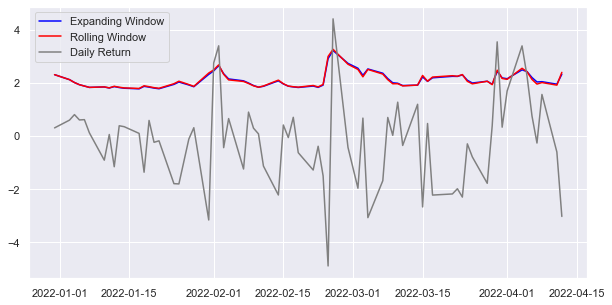

In [37]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(10,5))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(rf.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

In [38]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter   p-value
mu         0.169961  0.000223
omega      1.216205  0.095566
alpha[1]   0.200860  0.032117
beta[1]    0.606497  0.001358


In [39]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print parameter stats
print(para_summary)

          parameter   std-err   t-value
mu         0.169961  0.046045  3.691197
omega      1.216205  0.729691  1.666740
alpha[1]   0.200860  0.093730  2.142956
beta[1]    0.606497  0.189323  3.203495


In [40]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6    lag_7  \
P-values  0.285861  0.376888  0.551018  0.710185  0.484144  0.576478  0.59449   

            lag_8     lag_9    lag_10  
P-values  0.33831  0.425106  0.460579

In [41]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

Empty DataFrame
Columns: []
Index: [P-values]

In [42]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -5999.747081285208
Log-likelihood of skewt GARCH : -5650.205812787277


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(rf['Return'].sub(rf['Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 7.338
Mean Squared Error (MSE): 346.442


(7.338315007271676, 346.44205698951515)